In [1]:
import numpy as np
import os
import pandas as pd
import cv2
import mediapipe
import time
import random
from PIL import Image
from sklearn.utils import class_weight
import tensorflow as tf
from keras.applications.resnet import ResNet152, ResNet50, ResNet101
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition, svm
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import (
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    InputLayer,
    Activation,
    BatchNormalization,
    GlobalAveragePooling2D,
    Dropout,
    RandomFourierFeatures,
    Input,
)
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.preprocessing import image

# Functions and gridsearch

In [2]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

input_shape_mouth = (465, 930, 3) # mouth

# Define hyperparameters and their values for GridSearch
param_grid = {
    'learning_rate': [0.0001, 0.001],
    'hidden_layers': [1, 2],
}

combinations = [[0,0], [0,1], [1,0], [1,1]]

# Define hyperparameters and their values for GridSearch
param_grid2 = {
    'learning_rate': [0.0001, 0.001],
    'dropout_rate':  [0, 0.2],
    'hidden_layers': [1, 2],
}

combinations2 = [[0,0,0], [0,0,1], [0,1,0], [0,1,1], [1,0,0], [1,0,1], [1,1,0], [1,1,1]]

param_grid3 = {
    'conv_layers': [2, 3],
    #'dense_layers':  [1, 2],
    'epochs': [5, 10, 20],
}

combinations3 = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]]

# Preprocessing data

### Batches:

In [3]:
train_path = "rp_data\\train"
valid_path = "rp_data\\valid"
test_path = "rp_data\\test"

# Define image size and number of channels

# Mouth
img_height_mouth = 465
img_width_mouth = 930

# Eyes
img_height_eyes = 348
img_width_eyes = 697

# Change preprocess_input to the corresponding classifier (vgg16 for DNN/CNN and resnet for ResNet152)
train_batches = ImageDataGenerator(
    tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=train_path,
    target_size=(img_height_mouth, img_width_mouth),
    classes=["normal", "stroke"],
    batch_size=8,
)

valid_batches = ImageDataGenerator(
    tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=valid_path,
    target_size=(img_height_mouth, img_width_mouth),
    classes=["normal", "stroke"],
    batch_size=8,
)
test_batches = ImageDataGenerator(
    tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=test_path,
    target_size=(img_height_mouth, img_width_mouth),
    classes=["normal", "stroke"],
    batch_size=8,
    shuffle=False,
)

Found 3537 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


# DNN

In [25]:
model_DNN = Sequential()
model_DNN.add(Flatten())
model_DNN.add(Dense(64, activation="relu", input_shape=input_shape_mouth))
model_DNN.add(Dense(64, activation="relu"))
model_DNN.add(Dense(units=2, activation="softmax"))

model_DNN.compile(optimizer=Adam(0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model_DNN.fit(x=train_batches, validation_data=valid_batches, epochs=15, verbose=2)
score = model_DNN.evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

Epoch 1/15


c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


192/192 - 17s - loss: 110.7600 - accuracy: 0.5601 - val_loss: 120.8175 - val_accuracy: 0.5483 - 17s/epoch - 89ms/step
Epoch 2/15
192/192 - 16s - loss: 37.0958 - accuracy: 0.7587 - val_loss: 120.5916 - val_accuracy: 0.5168 - 16s/epoch - 85ms/step
Epoch 3/15
192/192 - 17s - loss: 28.0880 - accuracy: 0.8142 - val_loss: 99.6680 - val_accuracy: 0.5306 - 17s/epoch - 86ms/step
Epoch 4/15
192/192 - 16s - loss: 18.1097 - accuracy: 0.8821 - val_loss: 104.9292 - val_accuracy: 0.5404 - 16s/epoch - 85ms/step
Epoch 5/15
192/192 - 16s - loss: 13.3838 - accuracy: 0.8988 - val_loss: 93.7079 - val_accuracy: 0.5759 - 16s/epoch - 85ms/step
Epoch 6/15
192/192 - 17s - loss: 9.6797 - accuracy: 0.9242 - val_loss: 107.2478 - val_accuracy: 0.5187 - 17s/epoch - 86ms/step
Epoch 7/15
192/192 - 17s - loss: 10.8236 - accuracy: 0.9210 - val_loss: 116.0054 - val_accuracy: 0.5404 - 17s/epoch - 87ms/step
Epoch 8/15
192/192 - 16s - loss: 6.6087 - accuracy: 0.9448 - val_loss: 167.5210 - val_accuracy: 0.5187 - 16s/epoch - 

Sensitivity: 1.0
Specificity: 0.375
Confusion matrix, without normalization
[[3 5]
 [0 9]]


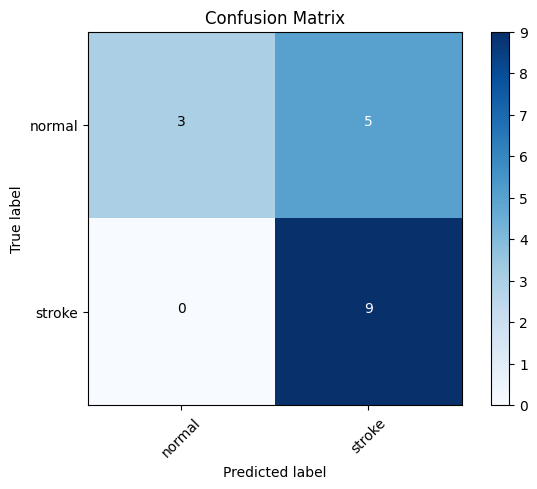

Test loss: 146.415283203125, Test accuracy 0.7058823704719543


In [26]:
predictions = model_DNN.predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

# CNN (mouth)

In [5]:
#scores_customCNN = []
#models_customCNN = []

lr = 0.0001

#conv_layers = param_grid3["conv_layers"][i[0]]
#dense_layers = param_grid3["dense_layers"][i[1]]
#epochs = param_grid3["epochs"][i[1]]
#print("Dense layers:", dense_layers)

model_customCNN = Sequential()
model_customCNN.add(Conv2D(
        filters=256,
        kernel_size=(6, 6),
        activation="relu",
        padding="same",
        input_shape=(img_height_mouth, img_width_mouth, 3),
    ))
model_customCNN.add(MaxPool2D(pool_size=(4, 4), strides=4))

model_customCNN.add(Conv2D(filters=512, kernel_size=(9, 9), activation="relu", padding="same"))
model_customCNN.add(MaxPool2D(pool_size=(4, 4), strides=4))
model_customCNN.add(Conv2D(filters=512, kernel_size=(9, 9), activation="relu", padding="same"))
model_customCNN.add(MaxPool2D(pool_size=(4, 4), strides=4))

model_customCNN.add(Flatten())
model_customCNN.add(Dense(512, activation="relu"))
model_customCNN.add(Dense(units=2, activation="softmax"))

#model_customCNN.summary()

model_customCNN.compile(
    optimizer=Adam(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model_customCNN.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)
# Save the weights
model_customCNN.save_weights('mouth_weights_10ep.h5')
score = model_customCNN.evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

Epoch 1/10
443/443 - 825s - loss: 2.5194 - accuracy: 0.8858 - val_loss: 0.4674 - val_accuracy: 0.8564 - 825s/epoch - 2s/step
Epoch 2/10
443/443 - 786s - loss: 0.0606 - accuracy: 0.9796 - val_loss: 0.8186 - val_accuracy: 0.8615 - 786s/epoch - 2s/step
Epoch 3/10
443/443 - 785s - loss: 0.0718 - accuracy: 0.9822 - val_loss: 1.0307 - val_accuracy: 0.8667 - 785s/epoch - 2s/step
Epoch 4/10
443/443 - 778s - loss: 0.0586 - accuracy: 0.9839 - val_loss: 1.0078 - val_accuracy: 0.8752 - 778s/epoch - 2s/step
Epoch 5/10
443/443 - 762s - loss: 0.0404 - accuracy: 0.9912 - val_loss: 0.8628 - val_accuracy: 0.8889 - 762s/epoch - 2s/step
Epoch 6/10
443/443 - 798s - loss: 0.0223 - accuracy: 0.9943 - val_loss: 1.0297 - val_accuracy: 0.8940 - 798s/epoch - 2s/step
Epoch 7/10
443/443 - 798s - loss: 0.0039 - accuracy: 0.9986 - val_loss: 1.3029 - val_accuracy: 0.8821 - 798s/epoch - 2s/step
Epoch 8/10
443/443 - 794s - loss: 0.0706 - accuracy: 0.9873 - val_loss: 1.0785 - val_accuracy: 0.8735 - 794s/epoch - 2s/step


Sensitivity: 0.9230769230769231
Specificity: 0.88
Confusion matrix, without normalization
[[22  3]
 [ 2 24]]


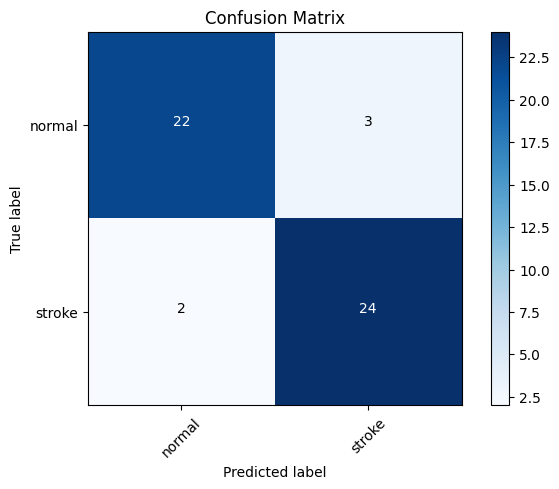

Test loss: 1.5106072425842285, Test accuracy 0.9019607901573181


In [6]:
predictions = model_customCNN.predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

# CNN (eyes)

In [26]:
#scores_customCNN = []
#models_customCNN = []

lr = 0.0001

#conv_layers = param_grid3["conv_layers"][i[0]]
#dense_layers = param_grid3["dense_layers"][i[1]]
#epochs = param_grid3["epochs"][i[1]]
#print("Dense layers:", dense_layers)

model_customCNN2 = Sequential()
model_customCNN2.add(Conv2D(
        filters=256,
        kernel_size=(6, 6),
        activation="relu",
        padding="same",
        input_shape=(img_height_eyes, img_width_eyes, 3),
    ))
model_customCNN2.add(MaxPool2D(pool_size=(4, 4), strides=4))

model_customCNN2.add(Conv2D(filters=512, kernel_size=(9, 9), activation="relu", padding="same"))
model_customCNN2.add(MaxPool2D(pool_size=(4, 4), strides=4))
model_customCNN2.add(Conv2D(filters=512, kernel_size=(9, 9), activation="relu", padding="same"))
model_customCNN2.add(MaxPool2D(pool_size=(4, 4), strides=4))

model_customCNN2.add(Flatten())
model_customCNN2.add(Dense(512, activation="relu"))
model_customCNN2.add(Dense(units=2, activation="softmax"))

#model_customCNN2.summary()

model_customCNN2.compile(
    optimizer=Adam(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model_customCNN2.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

# Save the weights
model_customCNN2.save_weights('eyes_weights.h5')
score = model_customCNN2.evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

Epoch 1/10


c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


383/383 - 402s - loss: 2.8550 - accuracy: 0.7707 - val_loss: 0.7115 - val_accuracy: 0.6746 - 402s/epoch - 1s/step
Epoch 2/10
383/383 - 390s - loss: 0.1030 - accuracy: 0.9605 - val_loss: 1.0034 - val_accuracy: 0.7041 - 390s/epoch - 1s/step
Epoch 3/10
383/383 - 396s - loss: 0.0366 - accuracy: 0.9869 - val_loss: 1.0852 - val_accuracy: 0.6923 - 396s/epoch - 1s/step
Epoch 4/10
383/383 - 396s - loss: 0.0788 - accuracy: 0.9752 - val_loss: 1.4082 - val_accuracy: 0.6982 - 396s/epoch - 1s/step
Epoch 5/10
383/383 - 393s - loss: 0.0300 - accuracy: 0.9918 - val_loss: 1.1431 - val_accuracy: 0.6982 - 393s/epoch - 1s/step
Epoch 6/10
383/383 - 393s - loss: 0.0640 - accuracy: 0.9794 - val_loss: 2.3313 - val_accuracy: 0.6686 - 393s/epoch - 1s/step
Epoch 7/10
383/383 - 393s - loss: 0.0192 - accuracy: 0.9928 - val_loss: 1.7970 - val_accuracy: 0.6686 - 393s/epoch - 1s/step
Epoch 8/10
383/383 - 396s - loss: 0.0648 - accuracy: 0.9843 - val_loss: 1.7479 - val_accuracy: 0.6667 - 396s/epoch - 1s/step
Epoch 9/10


Sensitivity: 0.8888888888888888
Specificity: 0.875
Confusion matrix, without normalization
[[7 1]
 [1 8]]


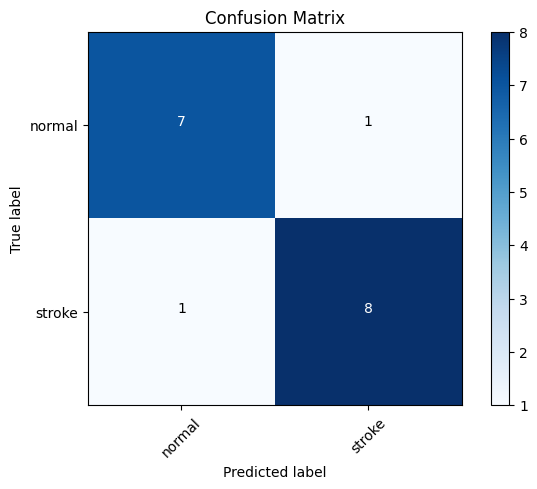

Test loss: 0.9892070889472961, Test accuracy 0.8823529481887817


In [27]:
predictions = model_customCNN2.predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

# Test the model with the webcam

In [84]:
model_test = Sequential()
model_test.add(Conv2D(
        filters=256,
        kernel_size=(6, 6),
        activation="relu",
        padding="same",
        input_shape=(img_height, img_width, 3),
    ))
model_test.add(MaxPool2D(pool_size=(4, 4), strides=4))

model_test.add(Conv2D(filters=512, kernel_size=(9, 9), activation="relu", padding="same"))
model_test.add(MaxPool2D(pool_size=(4, 4), strides=4))
model_test.add(Conv2D(filters=512, kernel_size=(9, 9), activation="relu", padding="same"))
model_test.add(MaxPool2D(pool_size=(4, 4), strides=4))

model_test.add(Flatten())
model_test.add(Dense(512, activation="relu"))
model_test.add(Dense(units=2, activation="softmax"))

# Load the weights from the saved file
model_test.load_weights('mouth_weights.h5')


## --- Webcam --- ##




# Load the image and preprocess it
img = Image.open("rp_data\\test\\stroke\\weak20.png")
#img = Image.open("D:\\Kandidatarbete\\rp_eyes\\test\\normal\\normal28.png")

img = img.resize((930, 465)) # Mouth
#img = img.resize((697, 348)) # Eyes


# Remove the alpha channel if present
if img.mode == 'RGBA':
    img = img.convert('RGB')
    
# Convert the image to a numpy array
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

# Use the model to predict on a new image
predictions = model_test.predict(img_array)

# Get the confidence score for the positive class
confidence_score_normal = predictions[0][0]
confidence_score_stroke = predictions[0][1]

print("Confidence score for normal:", confidence_score_normal)
print("Confidence score for stroke:", confidence_score_stroke)

# TODO: NIHSS points (also needs eye model weights)

1/1 [==============================] - 0s 48ms/step
Confidence score for normal: 4.2887127e-10
Confidence score for stroke: 1.0


# Pretrained Residual NN model (ResNet)

In [20]:
scores_resnet = []
models_resnet = []

for i in combinations:
    lr = param_grid['learning_rate'][i[0]]
    layers = param_grid['hidden_layers'][i[1]]
    print("Learning rate:", lr)
    print("Layers:", layers)

    # Create the base ResNet50 model
    base_model = ResNet152(weights="imagenet", include_top=False, input_shape=input_shape)

    # Add a global average pooling layer and a dense layer with softmax activation for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    for i in range(layers):
        x = Dense(128, activation="relu")(x)
    predictions = Dense(2, activation="softmax")(x)

    # Define the model to be trained with the ResNet50 base and the classification layers added
    model_resnet = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base ResNet50 layers so they are not updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with a learning rate of 0.001 and a categorical cross-entropy loss function
    model_resnet.compile(
        optimizer=Adam(lr=lr), loss="categorical_crossentropy", metrics=["accuracy"]
    )

    model_resnet.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)
    score = model_resnet.evaluate(test_batches, verbose=0)

    print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))
    
    scores_resnet.append(score)
    models_resnet.append(model_resnet)

print(scores_resnet)


Learning rate: 0.0001
Layers: 1
Epoch 1/5


c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


383/383 - 150s - loss: 0.4539 - accuracy: 0.8021 - val_loss: 0.5595 - val_accuracy: 0.7278 - 150s/epoch - 392ms/step
Epoch 2/5
383/383 - 140s - loss: 0.2872 - accuracy: 0.9059 - val_loss: 0.5612 - val_accuracy: 0.7396 - 140s/epoch - 364ms/step
Epoch 3/5
383/383 - 144s - loss: 0.2074 - accuracy: 0.9406 - val_loss: 0.5002 - val_accuracy: 0.7712 - 144s/epoch - 376ms/step
Epoch 4/5
383/383 - 141s - loss: 0.1460 - accuracy: 0.9700 - val_loss: 0.5052 - val_accuracy: 0.7633 - 141s/epoch - 369ms/step
Epoch 5/5
383/383 - 144s - loss: 0.1080 - accuracy: 0.9801 - val_loss: 0.5201 - val_accuracy: 0.7751 - 144s/epoch - 375ms/step
Test loss: 1.393337368965149, Test accuracy 0.6470588445663452
Learning rate: 0.0001
Layers: 2
Epoch 1/5
383/383 - 161s - loss: 0.4810 - accuracy: 0.7750 - val_loss: 0.5718 - val_accuracy: 0.7081 - 161s/epoch - 421ms/step
Epoch 2/5
383/383 - 152s - loss: 0.2644 - accuracy: 0.9086 - val_loss: 0.5349 - val_accuracy: 0.7771 - 152s/epoch - 398ms/step
Epoch 3/5
383/383 - 154s -

In [ ]:
score = models_resnet[2].evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy: {}".format(score[0], score[1]))

predictions = models_resnet[2].predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")